In [3]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm
import importlib  # Built-in module
from src import plotting
from src import utils
from src import tuning
from src import fp
from src import eig
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'


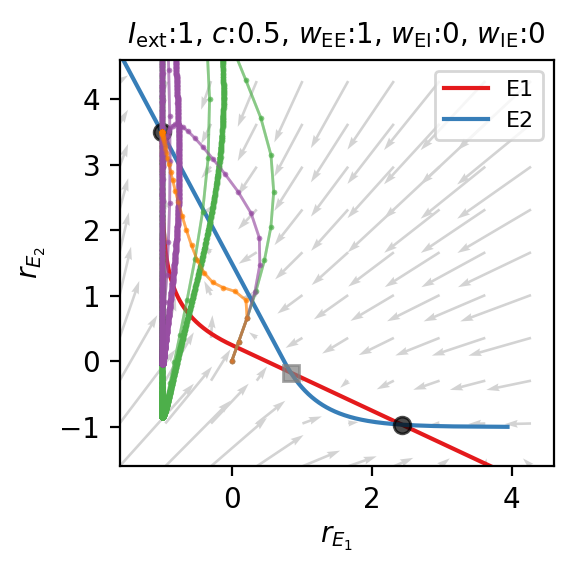

In [19]:
plotting = importlib.reload(plotting)
utils = importlib.reload(utils)
fp = importlib.reload(fp)
eig = importlib.reload(eig)
tuning = importlib.reload(tuning)
from src.plotting import colors

def update_plot_traj(order_by, coherence, wEEs, wIEs, wEIs, stimuli_strength, ordi, rE_limits, traj_init, taus):
    order_bys = {"wEE": wEEs,
                 "wIE": wIEs,
                 "wEI": wEIs,
                 }
    pars = utils.thesis_pars()
    T = 2000
    plot_size2 = len(stimuli_strength)
    plot_size = len(order_bys[order_by])
    if ordi == 1:
        plot_size, plot_size2 = plot_size2, plot_size
    fig, axes = plt.subplots(plot_size2, plot_size, figsize=(3* plot_size, 3 * plot_size2),
                             sharex='col', sharey='row',
                             squeeze=False,
                             )
    for wy in order_bys.keys():
        if wy != order_by:
            pars[wy] = order_bys[wy][0]
    # coherence = pars["coherence_range"][0]
    for ii, stimulus_strength in enumerate(stimuli_strength):
        for jj, y in enumerate(order_bys[order_by]):

            pars[order_by] = y

            if ordi == 1:
                ax = axes[jj, ii]
            else:
                ax = axes[ii, jj]

            pars["stimulus_strength"] = stimulus_strength

            I_ext_E1 = np.full((1, T), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, T), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            I_ext_I = np.zeros((2, T))

            Exc_null_rE0, Exc_null_rE1  = np.linspace(rE_limits[0], rE_limits[1], T), np.linspace(rE_limits[0], rE_limits[1], T)
            null_rE0, null_rE1 = np.zeros((1, T)), np.zeros((1, T))
            null_rI = np.zeros((2, T))
            null_rE0[0, :] = Exc_null_rE0
            null_rE1[0, :] = Exc_null_rE1
            null_rE = np.concatenate([null_rE0, null_rE1], axis=0)

            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = I_ext_I

            null_rE1_from_rE0 = utils.get_Eop_from_E_nullcline(0, null_rE, **pars)
            null_rE0_from_rE1 = utils.get_Eop_from_E_nullcline(1, null_rE, **pars)

            ax.plot(Exc_null_rE0, null_rE1_from_rE0, colors[0], label='E1')
            ax.plot(null_rE0_from_rE1, Exc_null_rE1, colors[1], label='E2')

            my_n_skip=2
            myscale=5

            I_ext_E1 = np.full((1, 400), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, 400), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = np.zeros((2, 400))
            pars['noise'] = np.zeros((2, 400))
            # pars['rI_init'] = np.zeros((2, 400))

            EE_grid = np.linspace(rE_limits[0], rE_limits[1], 20)
            rE1, rE2 = np.meshgrid(EE_grid, EE_grid)
            rE = np.stack([rE1.reshape(-1), rE2.reshape(-1)], axis=0)
            drEdt = utils.batch_EIderivs_E2(rE, **pars).reshape(2, 20, 20)
            rE = rE.reshape(2, 20, 20)
            n_skip = my_n_skip
            ax.quiver(rE[0, ::n_skip, ::n_skip], rE[1, ::n_skip, ::n_skip],
                      drEdt[0, ::n_skip, ::n_skip], drEdt[1, ::n_skip, ::n_skip],
                      angles='xy', scale_units='xy', scale=myscale, facecolor='lightgray')
            ax.set_ylim(rE_limits[0], rE_limits[1])
            ax.set_xlim(rE_limits[0], rE_limits[1])
            ax.set_xlabel(r'$r_{E_1}$', fontsize=10)
            # ie = r"$I_E$"
            # math_not = {"wEE": r"$w_{EE}$",
            #             "wIE": r"$w_{IE}$",
            #             "wEI": r"$w_{EI}$"}
            # ax.set_title(f"{ie}:{stimulus_strength}, {math_not[order_by]}:{y}")

            ie = r"$I_{\text{ext}}$"
            wee = r"$w_{\mathrm{EE}}$"
            wei = r"$w_{\mathrm{EI}}$"
            wie = r"$w_{\mathrm{IE}}$"
            wEE = y if order_by == "wEE" else wEEs[0]
            wEI = y if order_by == "wEI" else wEIs[0]
            wIE = y if order_by == "wIE" else wIEs[0]
            c = r"$c$"
            ax.set_title(f"{ie}:{stimulus_strength}, {c}:{coherence}, {wee}:{wEE}, {wei}:{wEI}, {wie}:{wIE}", fontsize=10)
            
            x_fps = []
            for rEini in [[rE_limits[0], rE_limits[1]], [rE_limits[1], rE_limits[0]], [rE_limits[0], rE_limits[0]], [rE_limits[1], rE_limits[1]]]:
                pars2 = utils.thesis_pars(rE_init=rEini, I_ext_E=I_ext_E[:,1])
                pars2[order_by] = y
                for wy in order_bys.keys():
                    if wy != order_by:
                        pars2[wy] = order_bys[wy][0]
                pars2["stimulus_strength"] = stimulus_strength
                # Find the fixed point
                x_fp1 = fp.my_fp_E2(**pars2)
                marker='o'
                color='k'

                eig_1, J, stability_cond = eig.get_eig_Jacobian_E2(x_fp1,  **pars2)

                if np.any(np.iscomplex(eig_1)) or np.any(eig_1 > 0):
                    marker = 's'
                    color='gray'

                exists = False
                for x_f in x_fps:
                    if abs(x_fp1[0] - x_f[0]) < 3e-1 and abs(x_fp1[1] == x_f[1]) < 3e-1:
                        exists = True
                        break
                if exists:
                    continue
                if fp.check_fp_E2(pars2, x_fp=x_fp1):
                    # plotting.plot_fp(x_fp1, ax=ax, eig=eig_1, marker=marker,color=color)
                    plotting.plot_fp(x_fp1, ax=ax, eig=None, marker=marker,color=color)
                    # print(rEini, x_fp1, eig_1)
                    x_fps.append(x_fp1)
                ax.legend(loc='best', fontsize=8)

                dx = 2
                n = 3
                Tp = 3000
                I_ext_E1_ = np.full((1, 1, Tp), stimulus_strength * (1 - coherence))
                I_ext_E2_ = np.full((1, 1, Tp), stimulus_strength * (1 + coherence))
                I_ext_E_ = np.concatenate([I_ext_E1_, I_ext_E2_], axis=1)
                I_ext_I_ = np.zeros((1, 2, Tp))
                pars3 = pars.copy()
                pars3['I_ext_E'] = I_ext_E_
                pars3['I_ext_I'] = I_ext_I_
                pars3['noise'] = np.zeros((1, 2, Tp))
                pars3['T'] = Tp

                # for p in range(n):
                #     for o in range(n):
                #         rE_init = [rE_limits[0] + dx * p, rE_limits[0] + dx * o]
                #         wEI = y if order_by == "wEI" else wEIs[0]
                #         W_EI = np.array([[1 + wEI, 1 - wEI], [1 - wEI, 1 + wEI]])
                #         rE_wEI = np.einsum("j,jk->k", rE_init, W_EI) 
                #         rI = pars["f_I"](rE_wEI, a=pars["a_I"], b=pars["b_I"], d=pars["d_I"])
                #         pars['rE_init'], pars['rI_init'] = rE_init, rI
                #         rE_tj, _ = utils.simulate_wc(**pars)
                #       
                #         ax.plot(rE_tj[0, 0], rE_tj[0, 1], colors[2], ls="-", lw=1, alpha=0.7)
                color_index = 0
                for idx, rE_init in enumerate(traj_init):
                    wEI = y if order_by == "wEI" else wEIs[0]
                    W_EI = np.array([[1 + wEI, 1 - wEI], [1 - wEI, 1 + wEI]])
                    rE_wEI = np.einsum("j,jk->k", rE_init, W_EI)
                    rI = pars3["f_I"](rE_wEI, a=pars3["a_I"], b=pars3["b_I"], d=pars3["d_I"])
                    pars3['rE_init'], pars3['rI_init'] = rE_init, rI
                    for tau_EI in taus:
                        pars3["tau_E"] = tau_EI[0]
                        pars3["tau_I"] = tau_EI[1]
                        rE_tj, _ = utils.simulate_wc(**pars3)

                        ax.plot(rE_tj[0, 0], rE_tj[0, 1], colors[2+color_index], marker='.', markersize=2,ls="-", lw=1, alpha=0.3)
                        color_index += 1


        if ordi == 1:
            axes[jj,0].set_ylabel(r'$r_{E_2}$', fontsize=10)
        else:
            axes[ii,0].set_ylabel(r'$r_{E_2}$', fontsize=10)
    plt.tight_layout()
    plt.show()

# update_plot(wEEs=[0, 0.5, 0.6, 0.8], stimuli_strength=[1], ordi=0, rE_limits = (-1,1))
# update_plot(wEEs=[0, 0.5, 0.6, 0.8], stimuli_strength=[0], ordi=0, rE_limits = (-2.5,2.5))
# update_plot(wEEs=[0,0.1,0.5], stimuli_strength=[0.2], ordi=0)

# update_plot_traj(order_by="wIE", wEEs=[1.], wIEs=[0.], wEIs=[0.], stimuli_strength=[0.1], ordi=0, rE_limits = (-1.6,4), traj_init=[[0.5, -1.5]], taus=[(5, 5), (5, 10), (10, 5)])


update_plot_traj(order_by="wIE", wEEs=[1], wIEs=[0], wEIs=[0], stimuli_strength=[1], ordi=0, rE_limits = (-1.6, 4.6), traj_init=[[0., 0.]], taus=[(5, 10), (5, 5), (5, 1)], coherence=0.5)
# 
# update_plot_traj(order_by="wIE", wEEs=[1], wIEs=[0], wEIs=[0], stimuli_strength=[1], ordi=0, rE_limits = (-1.6, 4.6), traj_init=[[0., 0.]], taus=[(100, 100)], coherence=0.5)